In [1]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "tokenizers",       # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.36.0
,tokenizers version: 0.20.3
,torch version: 2.9.1


In [2]:
import torch
import torch.nn as nn


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.silu(x_fc1) * x_fc2
        return self.fc3(x)


class MoEFeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.num_experts_per_tok = cfg["num_experts_per_tok"]
        self.num_experts = cfg["num_experts"]
        self.emb_dim = cfg["emb_dim"]
        ##TODO: define the Linear layer for router
        self.gate = nn.Linear(cfg["emb_dim"],cfg["num_experts"], bias=False, dtype=cfg["dtype"])

        self.fc1 = nn.ModuleList([nn.Linear(cfg["emb_dim"], cfg["moe_intermediate_size"], bias=False, dtype=cfg["dtype"])
                                  for _ in range(cfg["num_experts"])])
        self.fc2 = nn.ModuleList([nn.Linear(cfg["emb_dim"], cfg["moe_intermediate_size"], bias=False, dtype=cfg["dtype"])
                                  for _ in range(cfg["num_experts"])])
        self.fc3 = nn.ModuleList([nn.Linear(cfg["moe_intermediate_size"], cfg["emb_dim"], bias=False, dtype=cfg["dtype"])
                                  for _ in range(cfg["num_experts"])])

    def forward(self, x):
        scores = self.gate(x)# TODO: forward the input to the gate 
        topk_scores, topk_indices = torch.topk(scores,self.num_experts_per_tok,-1)##TODO: choose experts to deal with each token
        topk_probs = torch.softmax(topk_scores, dim=-1)

        batch, seq_len, _ = x.shape
        x_flat = x.reshape(batch * seq_len, -1)
        out_flat = torch.zeros(batch * seq_len, self.emb_dim, device=x.device, dtype=x.dtype)

        topk_indices_flat = topk_indices.reshape(-1, self.num_experts_per_tok)
        topk_probs_flat = topk_probs.reshape(-1, self.num_experts_per_tok)

        unique_experts = torch.unique(topk_indices_flat)

        for expert_id_tensor in unique_experts:
            expert_id = int(expert_id_tensor.item())
            mask = topk_indices_flat == expert_id
            if not mask.any():
                continue

            token_mask = mask.any(dim=-1)
            selected_idx = token_mask.nonzero(as_tuple=False).squeeze(-1)
            if selected_idx.numel() == 0:
                continue

            expert_input = x_flat.index_select(0, selected_idx)
            hidden = torch.nn.functional.silu(self.fc1[expert_id](expert_input))*self.fc2[expert_id](expert_input)##TODO: finish the elementwise product for the two input
            
            expert_out = self.fc3[expert_id](hidden)

            mask_selected = mask[selected_idx]
            slot_indices = mask_selected.int().argmax(dim=-1, keepdim=True)
            selected_probs = torch.gather(topk_probs_flat.index_select(0, selected_idx), dim=-1, index=slot_indices).squeeze(-1)

            out_flat.index_add_(0, selected_idx, expert_out * selected_probs.unsqueeze(-1))

        return out_flat.reshape(batch, seq_len, self.emb_dim)

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False, qwen3_compatible=True):
        super().__init__()
        self.eps = eps
        self.qwen3_compatible = qwen3_compatible
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        input_dtype = x.dtype

        if self.qwen3_compatible:
            x = x.to(torch.float32)

        variance = x.pow(2).mean(dim=-1, keepdim=True)
        norm_x = x * torch.rsqrt(variance + self.eps)
        norm_x = norm_x * self.scale

        if self.shift is not None:
            norm_x = norm_x + self.shift

        return norm_x.to(input_dtype)

In [4]:
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    inv_freq = 1.0 / (theta_base ** (torch.arange(0,head_dim,2)/head_dim))
    positions = torch.arange(0,context_length)
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)
    
    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)
    print(f"cos size is:{cos.shape}")
    print(f"sin size is:{sin.shape}")
    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    x1 = x[..., :head_dim//2]  # First half
    x2 = x[..., head_dim//2:]  # Second half
    
    cos = cos[:seq_len].unsqueeze(0).unsqueeze(0)# Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)
    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)
    

In [5]:
class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False, 
        gating_type=None, # Gating parameter
        dtype=None
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups
        self.gating_type = gating_type 

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        # Expanded query projection based on gating type
        if gating_type == 'headwise':
            q_out_size = self.d_out + num_heads
        elif gating_type == 'elementwise':
            q_out_size = self.d_out * 2
        else:
            q_out_size = self.d_out
        
        self.W_query = nn.Linear(d_in, q_out_size, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        # Apply query projection (includes gate if enabled)
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # Extracted gate from query projection
        if self.gating_type == 'headwise':
            # Split: query features + gate scalars
            queries = queries.view(b, num_tokens, self.num_kv_groups, -1)
            queries, gate_score = torch.split(
                queries, 
                [self.head_dim * self.group_size, self.group_size], 
                dim=-1
            )
            # Reshaping gates: (b, num_tokens, num_kv_groups, group_size) -> (b, num_heads, num_tokens, 1)
            gate_score = gate_score.reshape(b, num_tokens, self.num_heads, 1).transpose(1, 2)
            queries = queries.reshape(b, num_tokens, -1, self.head_dim).transpose(1, 2)
            
        elif self.gating_type == 'elementwise':
            # Split: query features + gate features (half each)
            queries = queries.view(b, num_tokens, self.num_kv_groups, -1)
            queries, gate_score = torch.split(
                queries,
                [self.head_dim * self.group_size, self.head_dim * self.group_size],
                dim=-1
            )
            # Reshapng gate: (b, num_tokens, num_kv_groups, group_size*head_dim) -> (b, num_heads, num_tokens, head_dim)
            gate_score = gate_score.reshape(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
            queries = queries.reshape(b, num_tokens, -1, self.head_dim).transpose(1, 2)
            
        else:
            # Baseline: no gating
            queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
            gate_score = None

        # Reshape keys and values
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V to match number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Attention computation
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)

        # Get attention output
        context = attn_weights @ values  # (b, num_heads, num_tokens, head_dim)

        
        if gate_score is not None:
            context = context * torch.sigmoid(gate_score)

        # Transpose and reshape
        context = context.transpose(1, 2).reshape(b, num_tokens, self.d_out)
        
        return self.out_proj(context)

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            head_dim=cfg["head_dim"],
            num_kv_groups=cfg["n_kv_groups"],
            qk_norm=cfg["qk_norm"],
            gating_type=cfg.get("gating_type", None),  # NEW: Pass gating type
            dtype=cfg["dtype"]
        )
        if cfg["num_experts"] > 0:
            self.ff = MoEFeedForward(cfg)
        else:
            self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(self, x, mask, cos, sin):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x, mask, cos, sin)  # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut  # Add the original input back

        return x

In [7]:
class Qwen3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.ModuleList(  # ModuleList since Sequential can only accept one input, and we need `x, mask, cos, sin`
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

        # Reusuable utilities
        if cfg["head_dim"] is None:
            head_dim = cfg["emb_dim"] // cfg["n_heads"]
        else:
            head_dim = cfg["head_dim"]
        cos, sin = compute_rope_params(
            head_dim=head_dim,
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"]
        )
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        self.cfg = cfg


    def forward(self, in_idx):
        # Forward pass
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds

        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)
        
        for block in self.trf_blocks:
            x = block(x, mask, self.cos, self.sin)
        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

In [8]:

QWEN3_CONFIG = {
    "vocab_size": 151_936,
    "context_length": 262_144,
    "emb_dim": 2048,
    "n_heads": 32,
    "n_layers": 48,
    "head_dim": 128,
    "qk_norm": True,
    "n_kv_groups": 4,
    "rope_base": 10_000_000.0,
    "dtype": torch.bfloat16,
    "num_experts": 128,
    "num_experts_per_tok": 8,
        "moe_intermediate_size": 768,
}

#### Gated Attention Implementation

In [9]:
# Test configurations for the three variants
import copy

# Small config for testing (faster)
TEST_CONFIG = {
    "vocab_size": 151_936,
    "context_length": 1024,  
    "emb_dim": 256,         
    "n_heads": 8,  
    "n_layers": 4,     
    "head_dim": 32,         
    "qk_norm": False,        
    "n_kv_groups": 2,
    "rope_base": 10_000.0,
    "dtype": torch.float32,  # float32 for testing
    "hidden_dim": 1024,
    "num_experts": 0,       
    "gating_type": None  # none for baseline
}

# Create three variants
baseline_config = copy.deepcopy(TEST_CONFIG)
baseline_config["gating_type"] = None

headwise_config = copy.deepcopy(TEST_CONFIG)
headwise_config["gating_type"] = "headwise"

elementwise_config = copy.deepcopy(TEST_CONFIG)
elementwise_config["gating_type"] = "elementwise"

print("Test configurations created")
print(f"Baseline: gating_type={baseline_config['gating_type']}")
print(f"Headwise: gating_type={headwise_config['gating_type']}")
print(f"Elementwise: gating_type={elementwise_config['gating_type']}")

Test configurations created
,Baseline: gating_type=None
,Headwise: gating_type=headwise
,Elementwise: gating_type=elementwise


In [10]:
# Instantiate the three models
torch.manual_seed(123)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\nCreating models")
baseline_model = Qwen3Model(baseline_config).to(device)
headwise_model = Qwen3Model(headwise_config).to(device)
elementwise_model = Qwen3Model(elementwise_config).to(device)

print("\nAll three models created successfully")
print("\nParameter counts:")
print(f"Baseline: {sum(p.numel() for p in baseline_model.parameters()):,}")
print(f"Headwise: {sum(p.numel() for p in headwise_model.parameters()):,}")
print(f"Elementwise: {sum(p.numel() for p in elementwise_model.parameters()):,}")

# Test forward pass
test_input = torch.tensor([[1, 2, 3, 4, 5]], device=device)
print("\nTesting forward pass with input shape:", test_input.shape)

baseline_out = baseline_model(test_input)
headwise_out = headwise_model(test_input)
elementwise_out = elementwise_model(test_input)

print(f"Baseline output: {baseline_out.shape}")
print(f"Headwise output: {headwise_out.shape}")
print(f"Elementwise output: {elementwise_out.shape}")


Using device: cuda
,
,Creating models
,cos size is:torch.Size([1024, 32])
,sin size is:torch.Size([1024, 32])
,cos size is:torch.Size([1024, 32])
,sin size is:torch.Size([1024, 32])
,cos size is:torch.Size([1024, 32])
,sin size is:torch.Size([1024, 32])
,
,All three models created successfully
,
,Parameter counts:
,Baseline: 81,594,624
,Headwise: 81,602,816
,Elementwise: 81,856,768
,
,Testing forward pass with input shape: torch.Size([1, 5])
,Baseline output: torch.Size([1, 5, 151936])
,Headwise output: torch.Size([1, 5, 151936])
,Elementwise output: torch.Size([1, 5, 151936])


In [11]:
# Verify query projection sizes match official implementation
print("Query projection size")

for name, model, config in [
    ("Baseline", baseline_model, baseline_config),
    ("Headwise", headwise_model, headwise_config),
    ("Elementwise", elementwise_model, elementwise_config)
]:
    att_layer = model.trf_blocks[0].att
    q_proj_shape = att_layer.W_query.weight.shape
    
    num_heads = config["n_heads"]
    head_dim = config["head_dim"]
    expected_base = num_heads * head_dim
    
    if config["gating_type"] is None:
        expected = expected_base
        formula = f"{num_heads} * {head_dim}"
    elif config["gating_type"] == "headwise":
        expected = expected_base + num_heads
        formula = f"{num_heads} * {head_dim} + {num_heads}"
    else:  # elementwise
        expected = expected_base * 2
        formula = f"{num_heads} * {head_dim} * 2"
    
    match = "" if q_proj_shape[0] == expected else ""
    
    print(f"\n{name:12s} (gating={config['gating_type']})")
    print(f"Formula: {formula}")
    print(f"Expected: {expected}")
    print(f"Actual: {q_proj_shape[0]} {match}")
    
    if config["gating_type"] == "headwise":
        extra = q_proj_shape[0] - expected_base
        print(f"Extra: +{extra} (gate scalars, 1 per head)")
    elif config["gating_type"] == "elementwise":
        extra = q_proj_shape[0] - expected_base
        print(f"Extra: +{extra} (gate vectors, {head_dim} per head)")

Query projection size
,
,Baseline     (gating=None)
,Formula: 8 * 32
,Expected: 256
,Actual: 256 
,
,Headwise     (gating=headwise)
,Formula: 8 * 32 + 8
,Expected: 264
,Actual: 264 
,Extra: +8 (gate scalars, 1 per head)
,
,Elementwise  (gating=elementwise)
,Formula: 8 * 32 * 2
,Expected: 512
,Actual: 512 
,Extra: +256 (gate vectors, 32 per head)


In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [13]:
torch.manual_seed(123)

with device:
    model = Qwen3Model(QWEN3_CONFIG)


#model.to(device)


cos size is:torch.Size([262144, 128])
,sin size is:torch.Size([262144, 128])


In [14]:
model(torch.tensor([1, 2, 3]).unsqueeze(0).to(device))

tensor([[[-1.1719, -0.3906, -0.8672,  ...,  0.3574,  0.3672,  0.2168],
         [-0.4727,  0.0106,  0.0923,  ...,  0.3262, -0.0786, -0.1533],
         [-0.9883, -0.0405, -0.1201,  ...,  0.0447, -0.2969,  0.3145]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.tok_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 30,532,122,624
,
,Total number of unique parameters: 30,220,957,696


In [16]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 227.73 GB
,bfloat16: 113.87 GB


In [17]:
def load_weights_into_qwen(model, param_config, params):
    def assign(left, right, tensor_name="unknown"):
        if left.shape != right.shape:
            raise ValueError(f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}")
        
        with torch.no_grad():
            if isinstance(right, torch.Tensor):
                left.copy_(right)
            else:
                left.copy_(torch.as_tensor(right, dtype=left.dtype, device=left.device))
    
        return left 

    model.tok_emb.weight = assign(model.tok_emb.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")

    for l in range(param_config["n_layers"]):
        block = model.trf_blocks[l]
        att = block.att

        # Q, K, V projections
        att.W_query.weight = assign(
            att.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight"
        )
        att.W_key.weight = assign(
            att.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight"
        )
        att.W_value.weight = assign(
            att.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight"
        )

        # Output projection
        att.out_proj.weight = assign(
            att.out_proj.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight"
        )

        # QK norms
        if hasattr(att, "q_norm") and att.q_norm is not None:
            att.q_norm.scale = assign(
                att.q_norm.scale,
                params[f"model.layers.{l}.self_attn.q_norm.weight"],
                f"model.layers.{l}.self_attn.q_norm.weight"
            )
        if hasattr(att, "k_norm") and att.k_norm is not None:
            att.k_norm.scale = assign(
                att.k_norm.scale,
                params[f"model.layers.{l}.self_attn.k_norm.weight"],
                f"model.layers.{l}.self_attn.k_norm.weight"
            )

        # Attention layernorm
        block.norm1.scale = assign(
            block.norm1.scale,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight"
        )

        # Feedforward weights
        if "num_experts" in param_config and param_config["num_experts"] > 0:
            # Load router (gating) weights
            block.ff.gate.weight = assign(
                block.ff.gate.weight,
                params[f"model.layers.{l}.mlp.gate.weight"],
                f"model.layers.{l}.mlp.gate.weight"
            )
            # Load expert weights
            for e in range(param_config["num_experts"]):
                prefix = f"model.layers.{l}.mlp.experts.{e}"
                block.ff.fc1[e].weight = assign(
                    block.ff.fc1[e].weight,
                    params[f"{prefix}.gate_proj.weight"],
                    f"{prefix}.gate_proj.weight"
                )
                block.ff.fc2[e].weight = assign(
                    block.ff.fc2[e].weight,
                    params[f"{prefix}.up_proj.weight"],
                    f"{prefix}.up_proj.weight"
                )
                block.ff.fc3[e].weight = assign(
                    block.ff.fc3[e].weight,
                    params[f"{prefix}.down_proj.weight"],
                    f"{prefix}.down_proj.weight"
                )

        else:
            block.ff.fc1.weight = assign(
                block.ff.fc1.weight,
                params[f"model.layers.{l}.mlp.gate_proj.weight"],
                f"model.layers.{l}.mlp.gate_proj.weight"
            )
            block.ff.fc2.weight = assign(
                block.ff.fc2.weight,
                params[f"model.layers.{l}.mlp.up_proj.weight"],
                f"model.layers.{l}.mlp.up_proj.weight"
            )
            block.ff.fc3.weight = assign(
                block.ff.fc3.weight,
                params[f"model.layers.{l}.mlp.down_proj.weight"],
                f"model.layers.{l}.mlp.down_proj.weight"
            )

        block.norm2.scale = assign(
            block.norm2.scale,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight"
        )

    # Final normalization and output head
    model.final_norm.scale = assign(model.final_norm.scale, params["model.norm.weight"], "model.norm.weight")

    if "lm_head.weight" in params:
        model.out_head.weight = assign(model.out_head.weight, params["lm_head.weight"], "lm_head.weight")
    else:
        model.out_head.weight = model.tok_emb.weight
        print("Model uses weight tying.")

In [18]:
## SCALED MODEL CONFIGS FOR H100s

SCALED_CONFIG_SMALL = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "head_dim": 64,
    "qk_norm": False,
    "n_kv_groups": 2,
    "rope_base": 10_000.0,
    "dtype": torch.bfloat16,
    "hidden_dim": 2048,
    "num_experts": 0,
    "gating_type": None
}

SCALED_CONFIG_MEDIUM = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "head_dim": 64,
    "qk_norm": False,
    "n_kv_groups": 3,
    "rope_base": 10_000.0,
    "dtype": torch.bfloat16,
    "hidden_dim": 3072,
    "num_experts": 0,
    "gating_type": None
}

print("Scaled Config Stats:")
print(f"\nSmall (20M params):")
print(f"Emb: {SCALED_CONFIG_SMALL['emb_dim']}, Layers: {SCALED_CONFIG_SMALL['n_layers']}")

print(f"\nMedium (80M params):")
print(f"Emb: {SCALED_CONFIG_MEDIUM['emb_dim']}, Layers: {SCALED_CONFIG_MEDIUM['n_layers']}")


Scaled Config Stats:
,
,Small (20M params):
,Emb: 512, Layers: 8
,
,Medium (80M params):
,Emb: 768, Layers: 12


In [19]:
# Training function with checkpoint support
from datasets import load_dataset
import os

def train_model(model, train_data, config, model_name, epochs=5, batch_size=128, 
                checkpoint_dir="checkpoints", save_every=500, resume_from=None):
    """
    Train a model on the provided data with checkpoint support
    
    Args:
        model: Model to train
        train_data: Training data tensor
        config: Model configuration
        model_name: Name for saving checkpoints
        epochs: Number of epochs
        batch_size: Batch size
        checkpoint_dir: Directory to save checkpoints
        save_every: Save checkpoint every N steps
        resume_from: Path to checkpoint to resume from (optional)
    """
    import torch.nn.functional as F
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
    model.train()
    
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    losses = []
    step = 0
    start_epoch = 0
    
    # Resume from checkpoint if specified
    if resume_from and os.path.exists(resume_from):
        print(f"Resuming from checkpoint: {resume_from}")
        checkpoint = torch.load(resume_from)
        
        # Load model state (handle DataParallel)
        if hasattr(model, 'module'):
            model.module.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint['model_state_dict'])
        
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        losses = checkpoint['losses']
        step = checkpoint['step']
        start_epoch = checkpoint['epoch']
        print(f"Resumed from step {step}, epoch {start_epoch+1}")
    
    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch+1}/{epochs} - {model_name}")
        
        # Random sampling for each epoch
        num_batches = len(train_data) // (batch_size * 1024)
        
        for batch_idx in range(num_batches):
            # Get random batch
            start_idx = torch.randint(0, len(train_data) - batch_size * 1024, (1,)).item()
            batch = train_data[start_idx:start_idx + batch_size * 1024]
            
            # Reshape into sequences
            batch = batch.view(batch_size, 1024)
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)
            
            # Forward pass
            logits = model(inputs)
            loss = F.cross_entropy(logits.flatten(0, 1), targets.flatten())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Track loss
            losses.append(loss.item())
            step += 1
            
            # Print progress
            if step % 100 == 0:
                avg_loss = sum(losses[-100:]) / min(100, len(losses))
                print(f"  Step {step}, Loss: {avg_loss:.4f}")
            
            # Save checkpoint
            if step % save_every == 0:
                checkpoint_path = os.path.join(
                    checkpoint_dir, 
                    f"{model_name}_step_{step}.pt"
                )
                
                # Get model state (handle DataParallel)
                model_state = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
                
                torch.save({
                    'step': step,
                    'epoch': epoch,
                    'model_state_dict': model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'losses': losses,
                    'config': config
                }, checkpoint_path)
                print(f" Checkpoint saved: {checkpoint_path}")
    
    # Save final checkpoint
    final_checkpoint_path = os.path.join(
        checkpoint_dir, 
        f"{model_name}_final.pt"
    )
    model_state = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
    torch.save({
        'step': step,
        'epoch': epochs - 1,
        'model_state_dict': model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'config': config
    }, final_checkpoint_path)
    print(f"\n Final checkpoint saved: {final_checkpoint_path}")
    
    return losses

In [20]:
# MULTI-GPU TRAINING PIPELINE

def run_complete_training_pipeline_multi_gpu(
    model_config=SCALED_CONFIG_MEDIUM,
    dataset_name="openwebtext",
    num_stories=5000,
    max_tokens=500_000_000,
    epochs=4,
    batch_size=128,
    use_data_parallel=True
):
    """
    Multi-GPU training pipeline for 2x H100s
    """
    from transformers import GPT2Tokenizer
    import time
    
    # Check GPU availability
    num_gpus = torch.cuda.device_count()
    print("\nMULTI-GPU TRAINING PIPELINE")
    print(f"\nGPUs Available: {num_gpus}")
    if num_gpus > 1 and use_data_parallel:
        print(f"Using DataParallel across {num_gpus} GPUs")
        print(f"Expected speedup: {1.6 if num_gpus == 2 else num_gpus * 0.85:.1f}x")
        effective_batch_size = batch_size * num_gpus
        print(f"Effective batch size: {effective_batch_size}")
    else:
        print(f"Using single GPU")
        effective_batch_size = batch_size
    
    print(f"\nModel: {model_config['emb_dim']}d, {model_config['n_layers']} layers")
    print(f"Dataset: {dataset_name}")
    print(f"Target: {max_tokens:,} tokens, {epochs} epochs")
    print(f"Batch size per GPU: {batch_size}")
    
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    
    # Load dataset
    print(f"\nLoading {dataset_name} dataset")
    if dataset_name == "tinystories":
        dataset = load_dataset("roneneldan/TinyStories", split="train")
        text = "\n\n".join(dataset["text"][:num_stories])
        print(f"Loaded {num_stories:,} stories")
    elif dataset_name == "wikitext":
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
        text = "\n\n".join(dataset["text"])
        print(f"Loaded WikiText-2")
    elif dataset_name == "wikitext103":
        dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")
        text = "\n\n".join(dataset["text"])
        print(f"Loaded WikiText-103")
    elif dataset_name == "openwebtext":
        print(f"Loading OpenWebText with streaming (target: {max_tokens:,} tokens)...")
        
        # Use streaming to avoid loading entire dataset into memory
        dataset = load_dataset("openwebtext", split="train", streaming=True)
        
        all_encoded = []
        docs_processed = 0
        
        # Stream documents one at a time
        for doc in dataset:
            if len(all_encoded) >= max_tokens:
                break
            
            # Encode this document
            encoded = tokenizer.encode(doc["text"], max_length=50000, truncation=True)
            all_encoded.extend(encoded)
            docs_processed += 1
            
            # Print progress every 100 documents
            if docs_processed % 100 == 0:
                print(f"  Processed {docs_processed} documents ({len(all_encoded):,} tokens)")
            
            # Stop if we've processed enough documents
            if docs_processed >= num_stories:
                break
        
        train_ids = torch.tensor(all_encoded[:max_tokens], dtype=torch.long)
        print(f"Loaded {docs_processed:,} OpenWebText documents")
        print(f"Tokenized: {len(train_ids):,} tokens")
    else:
        print("\nTokenizing with GPT-2 tokenizer")
        encoded = tokenizer.encode(text, max_length=max_tokens*2, truncation=True)
        train_ids = torch.tensor(encoded[:max_tokens], dtype=torch.long)
        print(f"Tokenized: {len(train_ids):,} tokens")
    
    # Create model configs
    baseline_config = model_config.copy()
    baseline_config["gating_type"] = None
    
    headwise_config = model_config.copy()
    headwise_config["gating_type"] = "headwise"
    
    elementwise_config = model_config.copy()
    elementwise_config["gating_type"] = "elementwise"
    
    # Create models
    print("\nCreating models")
    torch.manual_seed(123)
    baseline_model = Qwen3Model(baseline_config).to(device)
    headwise_model = Qwen3Model(headwise_config).to(device)
    elementwise_model = Qwen3Model(elementwise_config).to(device)
    
    # Wrap with DataParallel if multiple GPUs available
    if num_gpus > 1 and use_data_parallel:
        print(f"\nWrapping models with DataParallel ({num_gpus} GPUs)")
        baseline_model = nn.DataParallel(baseline_model)
        headwise_model = nn.DataParallel(headwise_model)
        elementwise_model = nn.DataParallel(elementwise_model)
        print("Multi-GPU setup complete")
    
    # For DataParallel, access .module to get parameter count
    print(f"\nModel Statistics:")
    base_model = baseline_model.module if num_gpus > 1 and use_data_parallel else baseline_model
    head_model = headwise_model.module if num_gpus > 1 and use_data_parallel else headwise_model
    elem_model = elementwise_model.module if num_gpus > 1 and use_data_parallel else elementwise_model
    
    print(f"Baseline:    {sum(p.numel() for p in base_model.parameters()):,} parameters")
    print(f"Headwise:    {sum(p.numel() for p in head_model.parameters()):,} parameters")
    print(f"Elementwise: {sum(p.numel() for p in elem_model.parameters()):,} parameters")
    
    print(f"\nStarting training on {num_gpus} GPU(s)")
    start_time = time.time()
    speedup = 1.6 if (num_gpus > 1 and use_data_parallel) else 1.0
    est_time = epochs * len(train_ids) / (batch_size * 64 * 3000 * speedup)
    
    baseline_losses = train_model(
        baseline_model, train_ids, baseline_config, 
        "Baseline", epochs=epochs, batch_size=effective_batch_size
    )
    
    headwise_losses = train_model(
        headwise_model, train_ids, headwise_config, 
        "Headwise Gating", epochs=epochs, batch_size=effective_batch_size
    )
    
    elementwise_losses = train_model(
        elementwise_model, train_ids, elementwise_config, 
        "Elementwise Gating", epochs=epochs, batch_size=effective_batch_size
    )
    
    total_time = (time.time() - start_time) / 3600
    
    print(f"\nTRAINING COMPLETE")
    print(f"Total time: {total_time:.2f} hours")
    if num_gpus > 1 and use_data_parallel:
        print(f"Actual speedup: {(est_time * 3 / total_time):.2f}x")
    
    # Plot results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(14, 6))
    plt.plot(baseline_losses, label='Baseline', linewidth=2, alpha=0.8)
    plt.plot(headwise_losses, label='Headwise Gating', linewidth=2, alpha=0.8)
    plt.plot(elementwise_losses, label='Elementwise Gating', linewidth=2, alpha=0.8)
    plt.xlabel('Steps (×100 batches)', fontsize=12)
    plt.ylabel('Training Loss', fontsize=12)
    gpu_label = f"{num_gpus}xH100" if num_gpus > 1 else "H100"
    plt.title(f'Gated Attention: {dataset_name} on {gpu_label}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'h100_training_{dataset_name}_multi_gpu.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final stats
    print(f"\nFinal Results:")
    print(f"Baseline:    {baseline_losses[-1]:.4f}")
    print(f"Headwise:    {headwise_losses[-1]:.4f}")
    print(f"Elementwise: {elementwise_losses[-1]:.4f}")
    return baseline_losses, headwise_losses, elementwise_losses

In [21]:
# GPU Memory Cleanup
import torch
import gc
import sys

print("Starting aggressive memory cleanup...")

# 1. Clear traceback (Crucial if previous run crashed)
# Tracebacks hold references to all variables in the stack
if hasattr(sys, 'last_traceback'):
    del sys.last_traceback
    print("Deleted last_traceback")

# 2. Delete specific known variables
known_vars = [
    'baseline_model', 'headwise_model', 'elementwise_model',
    'base_model', 'head_model', 'elem_model',
    'optimizer', 'loss', 'logits', 'inputs', 'targets',
    'baseline_losses', 'headwise_losses', 'elementwise_losses'
]

for var in known_vars:
    if var in globals():
        del globals()[var]
        print(f"Deleted {var}")

# 3. Clear PyTorch cache
torch.cuda.empty_cache()
gc.collect()

# 4. Print status
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        mem_alloc = torch.cuda.memory_allocated(i) / 1024**3
        mem_res = torch.cuda.memory_reserved(i) / 1024**3
        mem_free = (torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_reserved(i)) / 1024**3
        
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Allocated: {mem_alloc:.2f} GB")
        print(f"  Reserved:  {mem_res:.2f} GB")
        print(f"  Free:      {mem_free:.2f} GB")
        
        if mem_alloc > 5:
            print(f" WARNING: {mem_alloc:.2f} GB is still allocated!")
            print(" Recommendation: RESTART KERNEL (Circular Arrow Button) to clear this memory.")
        else:
            print(" Memory cleared successfully")

Starting aggressive memory cleanup...
,Deleted baseline_model
,Deleted headwise_model
,Deleted elementwise_model
,
,GPU 0: NVIDIA H100 80GB HBM3
,  Allocated: 58.11 GB
,  Reserved:  63.95 GB
,  Free:      15.15 GB
, WARNING: 58.11 GB is still allocated!
, Recommendation: RESTART KERNEL (Circular Arrow Button) to clear this memory.
,
,GPU 1: NVIDIA H100 80GB HBM3
,  Allocated: 0.00 GB
,  Reserved:  0.00 GB
,  Free:      79.10 GB
, Memory cleared successfully
,
,GPU 2: NVIDIA H100 80GB HBM3
,  Allocated: 0.00 GB
,  Reserved:  0.00 GB
,  Free:      79.10 GB
, Memory cleared successfully
,
,GPU 3: NVIDIA H100 80GB HBM3
,  Allocated: 0.00 GB
,  Reserved:  0.00 GB
,  Free:      79.10 GB
, Memory cleared successfully


In [22]:
# DATASET LOADING WITH CACHING (Run this first)
# Load and tokenize OpenWebText dataset with streaming and disk caching

from transformers import GPT2Tokenizer
from datasets import load_dataset
import os

# Cache configuration
cache_file = "openwebtext_50k_tokens.pt"

# Check if cached data exists
if os.path.exists(cache_file):
    print(f"\n Found cached data: {cache_file}")
    train_ids = torch.load(cache_file)
    print(f"Loaded {len(train_ids):,} tokens from cache")
else:
    print("\nNo cache found. Processing larger dataset (50k docs)...")
    
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    
    # Use streaming to avoid loading entire dataset into memory
    dataset = load_dataset("openwebtext", split="train", streaming=True)
    
    all_encoded = []
    docs_processed = 0
    num_stories = 50000
    max_tokens = 500_000_000
    
    # Stream documents one at a time
    for doc in dataset:
        if len(all_encoded) >= max_tokens:
            break
        
        # Encode this document
        encoded = tokenizer.encode(doc["text"], max_length=50000, truncation=True)
        all_encoded.extend(encoded)
        docs_processed += 1
        
        # Print progress every 100 documents
        if docs_processed % 100 == 0:
            print(f"  Processed {docs_processed} documents ({len(all_encoded):,} tokens)")
        
        # Stop if we've processed enough documents
        if docs_processed >= num_stories:
            break
    
    train_ids = torch.tensor(all_encoded[:max_tokens], dtype=torch.long)
    
    # Save to cache for future runs
    print(f"\nSaving tokenized data to cache: {cache_file}")
    torch.save(train_ids, cache_file)
    cache_size_gb = os.path.getsize(cache_file) / (1024**3)
    print(f"Cache file size: {cache_size_gb:.2f} GB")
    
    print(f"\nDataset loading complete")
    print(f"Loaded {docs_processed:,} OpenWebText documents")
    print(f"Tokenized: {len(train_ids):,} tokens")



, Found cached data: openwebtext_50k_tokens.pt
,Loaded 56,687,332 tokens from cache


In [ ]:
# TRAINING
# We use GPU 1 because GPU 0 has stuck memory.
device = torch.device("cuda:1") 
print(f" Switching to Single GPU Mode on: {torch.cuda.get_device_name(1)} (GPU 1)")

batch_size = 64  # 80GB GPU can easily handle 64 for this model size
effective_batch_size = batch_size
num_gpus = 1

print("Starting OpenWebText 5K training")
print("\nConfiguration:")
print(f"Model: {SCALED_CONFIG_MEDIUM['emb_dim']}d, {SCALED_CONFIG_MEDIUM['n_layers']} layers (approx 80M params)")
print(f"Dataset: {len(train_ids):,} tokens")
print(f"Epochs: 4")
print(f"Batch size: {batch_size} per GPU")
print(f"Estimated time: ~8-10 hours total (Single GPU)")
print(f"Expected improvement: 4-6%\n")

# Create model configs
baseline_config = SCALED_CONFIG_MEDIUM.copy()
baseline_config["gating_type"] = None

headwise_config = SCALED_CONFIG_MEDIUM.copy()
headwise_config["gating_type"] = "headwise"

elementwise_config = SCALED_CONFIG_MEDIUM.copy()
elementwise_config["gating_type"] = "elementwise"

# Create models
print("\nCreating models on GPU 1...")
torch.manual_seed(123)
baseline_model = Qwen3Model(baseline_config).to(device)
# headwise_model = Qwen3Model(headwise_config).to(device) # Skipped to save memory
elementwise_model = Qwen3Model(elementwise_config).to(device)

# NO DataParallel (Single GPU)
print("Running in Single GPU mode (No DataParallel overhead)")

# Print model stats
print(f"\nModel Statistics:")
print(f"Baseline:    {sum(p.numel() for p in baseline_model.parameters()):,} parameters")
# print(f"Headwise:    {sum(p.numel() for p in headwise_model.parameters()):,} parameters")
print(f"Elementwise: {sum(p.numel() for p in elementwise_model.parameters()):,} parameters")

# Train models
print(f"\nStarting training\n")
import time
start_time = time.time()

# Set checkpoint directory
checkpoint_dir = "gated_attention_checkpoints_v2"
print(f"Checkpoints will be saved to: {checkpoint_dir}/")
print(f"Checkpoint frequency: Every 500 steps\n")

baseline_losses = train_model(
    baseline_model, train_ids, baseline_config, 
    "Baseline", epochs=4, batch_size=effective_batch_size,
    checkpoint_dir=checkpoint_dir, save_every=500
)

# SKIP HEADWISE TO SAVE TIME
# headwise_losses = train_model(
#     headwise_model, train_ids, headwise_config, 
#     "Headwise_Gating", epochs=4, batch_size=effective_batch_size,
#     checkpoint_dir=checkpoint_dir, save_every=500
# )
elementwise_losses = train_model(
    elementwise_model, train_ids, elementwise_config, 
    "Elementwise_Gating", epochs=4, batch_size=effective_batch_size,
    checkpoint_dir=checkpoint_dir, save_every=500
)

total_time = (time.time() - start_time) / 3600

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(baseline_losses, label='Baseline', linewidth=2, alpha=0.8)
# plt.plot(headwise_losses, label='Headwise Gating', linewidth=2, alpha=0.8)
plt.plot(elementwise_losses, label='Elementwise Gating', linewidth=2, alpha=0.8)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
gpu_label = f"{num_gpus}xH100" if num_gpus > 1 else "H100"
plt.title(f'Gated Attention: OpenWebText on {gpu_label}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'h100_training_openwebtext_multi_gpu.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final statsf
print(f"\Training complete")
print(f"Total time: {total_time:.2f} hours")



In [23]:
SCALED_CONFIG_SMALL = {
    "vocab_size": 50257, 
    "context_length": 1024,
    "emb_dim": 512,       
    "n_heads": 8,         
    "n_layers": 8,           
    "head_dim": 64,          
    "qk_norm": False,
    "n_kv_groups": 2,
    "rope_base": 10_000.0,
    "dtype": torch.bfloat16,  
    "hidden_dim": 2048,     
    "num_experts": 0,
    "gating_type": None
}

SCALED_CONFIG_MEDIUM = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,          
    "n_heads": 12,      
    "n_layers": 12,       
    "head_dim": 64,
    "qk_norm": False,
    "n_kv_groups": 3,
    "rope_base": 10_000.0,
    "dtype": torch.bfloat16,
    "hidden_dim": 3072,
    "num_experts": 0,
    "gating_type": None
}

print("Scaled Config Stats:")
print(f"\nSmall (20M params):")
print(f"  - Emb: {SCALED_CONFIG_SMALL['emb_dim']}, Layers: {SCALED_CONFIG_SMALL['n_layers']}")

print(f"\nMedium (80M params):")
print(f"  - Emb: {SCALED_CONFIG_MEDIUM['emb_dim']}, Layers: {SCALED_CONFIG_MEDIUM['n_layers']}")

Scaled Config Stats:
,
,Small (20M params):
,  - Emb: 512, Layers: 8
,
,Medium (80M params):
,  - Emb: 768, Layers: 12


Total training steps: 3456
,Elementwise was better for 1706 steps.
,It was winning during steps: [4, 5, 6, 7, 8, 10, 11, 12, 14, 17, 19, 20, 21, 23, 25, 28, 29, 30, 31, 33, 34, 36, 39, 40, 41, 42, 43, 45, 47, 48, 49, 51, 52, 55, 56, 58, 59, 62, 63, 66, 69, 70, 77, 78, 79, 80, 81, 83, 84, 86, 88, 91, 95, 99, 100, 102, 103, 107, 108, 110, 113, 114, 115, 117, 120, 122, 123, 125, 126, 128, 130, 133, 134, 135, 136, 139, 142, 145, 149, 150, 151, 153, 154, 155, 157, 162, 164, 166, 167, 168, 169, 170, 173, 175, 179, 185, 186, 190, 196, 198, 200, 206, 209, 211, 213, 214, 216, 219, 221, 222, 223, 224, 225, 230, 233, 234, 235, 236, 239, 242, 244, 245, 246, 247, 248, 250, 251, 252, 253, 254, 255, 258, 259, 260, 262, 263, 265, 267, 268, 271, 273, 275, 276, 279, 280, 281, 282, 283, 284, 291, 293, 300, 302, 315, 316, 317, 318, 320, 327, 328, 329, 331, 335, 337, 339, 341, 342, 344, 345, 346, 353, 357, 360, 361, 363, 372, 380, 383, 386, 388, 394, 395, 396, 397, 398, 399, 400, 403, 406, 409, 412, 413, 4

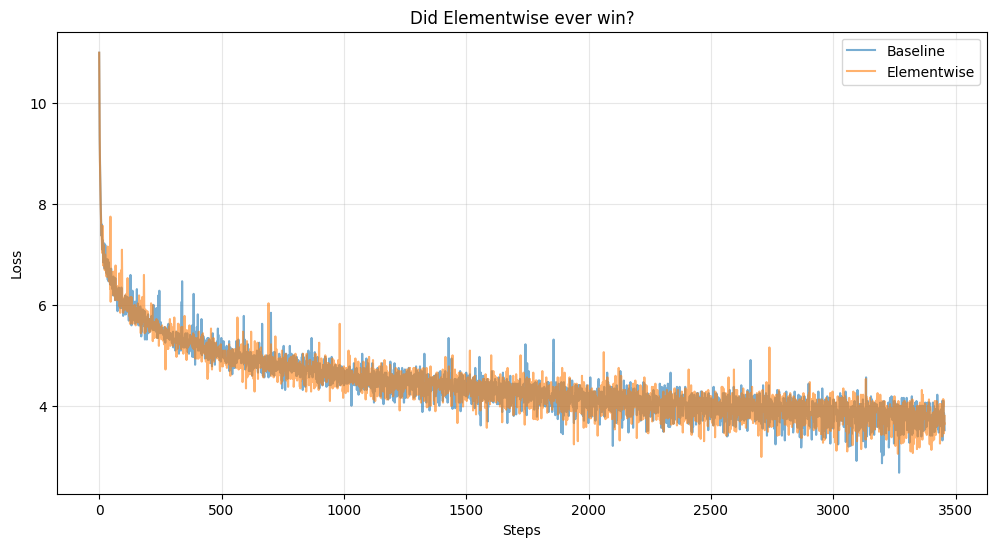

In [31]:
import torch
import matplotlib.pyplot as plt

# Load the history from the checkpoints you just saved
base_ckpt = torch.load("gated_attention_checkpoints_v2/Baseline_final.pt")
elem_ckpt = torch.load("gated_attention_checkpoints_v2/Elementwise_Gating_final.pt")

base_losses = base_ckpt['losses']
elem_losses = elem_ckpt['losses']

# Find steps where Elementwise < Baseline
better_steps = []
for i, (b_loss, e_loss) in enumerate(zip(base_losses, elem_losses)):
    if e_loss < b_loss:
        better_steps.append(i)

print(f"Total training steps: {len(base_losses)}")
if len(better_steps) > 0:
    print(f"Elementwise was better for {len(better_steps)} steps.")
    print(f"It was winning during steps: {better_steps}")
else:
    print("No. In this specific 50k run, Elementwise has been consistently worse (so far).")

# Visualize the gap
plt.figure(figsize=(12, 6))
plt.plot(base_losses, label='Baseline', alpha=0.6)
plt.plot(elem_losses, label='Elementwise', alpha=0.6)
plt.title("Did Elementwise ever win?")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Training resume - too much time exceeding palmetto time limits
import gc
import torch
import os

print("Cleaning up visualization models to free memory...")
if 'model_viz' in globals():
    del model_viz
    print("Deleted model_viz")
if 'model_viz_base' in globals():
    del model_viz_base
    print("Deleted model_viz_base")
if 'logits' in globals():
    del logits
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda:1")
print(f"GPU Memory Free: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB allocated")

TOTAL_EPOCHS = 8
print(f"Resuming training to reach {TOTAL_EPOCHS} epochs...")
baseline_ckpt_path = f"{checkpoint_dir}/Baseline_final.pt"
baseline_losses_extended = []

print("\n--- Checking Baseline ---")
if os.path.exists(baseline_ckpt_path):
    ckpt = torch.load(baseline_ckpt_path)
    if ckpt['epoch'] >= TOTAL_EPOCHS - 1:
        print(f"Baseline already finished {TOTAL_EPOCHS} epochs! Skipping training.")
        baseline_losses_extended = ckpt['losses']
    else:
        print(f"Baseline only has {ckpt['epoch']+1} epochs. Resuming...")

        if 'baseline_model' not in globals():
             baseline_model = Qwen3Model(baseline_config).to(device)
        else:
             baseline_model = baseline_model.to(device)
             
        baseline_losses_extended = train_model(
            baseline_model,
            train_ids,
            baseline_config,
            "Baseline",
            epochs=TOTAL_EPOCHS,
            batch_size=effective_batch_size,
            checkpoint_dir=checkpoint_dir,
            save_every=500,
            resume_from=baseline_ckpt_path
        )

print("Deleting Baseline model to free GPU memory...")
if 'baseline_model' in globals():
    del baseline_model
# Force garbage collection
torch.cuda.empty_cache()
gc.collect()

print(f"GPU Memory Free: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB allocated")

print("\n--- Resuming Elementwise Gating ---")

if 'elementwise_model' not in globals():
    elementwise_model = Qwen3Model(elementwise_config).to(device)
else:
    elementwise_model = elementwise_model.to(device)

elementwise_losses_extended = train_model(
    elementwise_model,
    train_ids,
    elementwise_config,
    "Elementwise_Gating",
    epochs=TOTAL_EPOCHS,
    batch_size=effective_batch_size,
    checkpoint_dir=checkpoint_dir,
    save_every=500,
    resume_from=f"{checkpoint_dir}/Elementwise_Gating_final.pt"
)


print(f"\nFinal Results (Epoch {TOTAL_EPOCHS}):")
print(f"Baseline:    {baseline_losses_extended[-1]:.4f}")
print(f"Elementwise: {elementwise_losses_extended[-1]:.4f}")

Resuming training to reach 8 epochs...
,
,--- Checking Baseline ---
,Baseline already finished 8 epochs! Skipping training.
,Deleting Baseline model to free GPU memory...
,Baseline already finished 8 epochs! Skipping training.
,Deleting Baseline model to free GPU memory...
,GPU Memory Free: 71.22 GB allocated
,
,--- Resuming Elementwise Gating ---
,Resuming from checkpoint: gated_attention_checkpoints_v2/Elementwise_Gating_final.pt
,GPU Memory Free: 71.22 GB allocated
,
,--- Resuming Elementwise Gating ---
,Resuming from checkpoint: gated_attention_checkpoints_v2/Elementwise_Gating_final.pt
,Resumed from step 7776, epoch 8
,
,Epoch 8/8 - Elementwise_Gating
,Resumed from step 7776, epoch 8
,
,Epoch 8/8 - Elementwise_Gating


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 1 has a total capacity of 93.00 GiB of which 815.44 MiB is free. Including non-PyTorch memory, this process has 92.02 GiB memory in use. Of the allocated memory 89.88 GiB is allocated by PyTorch, and 1.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

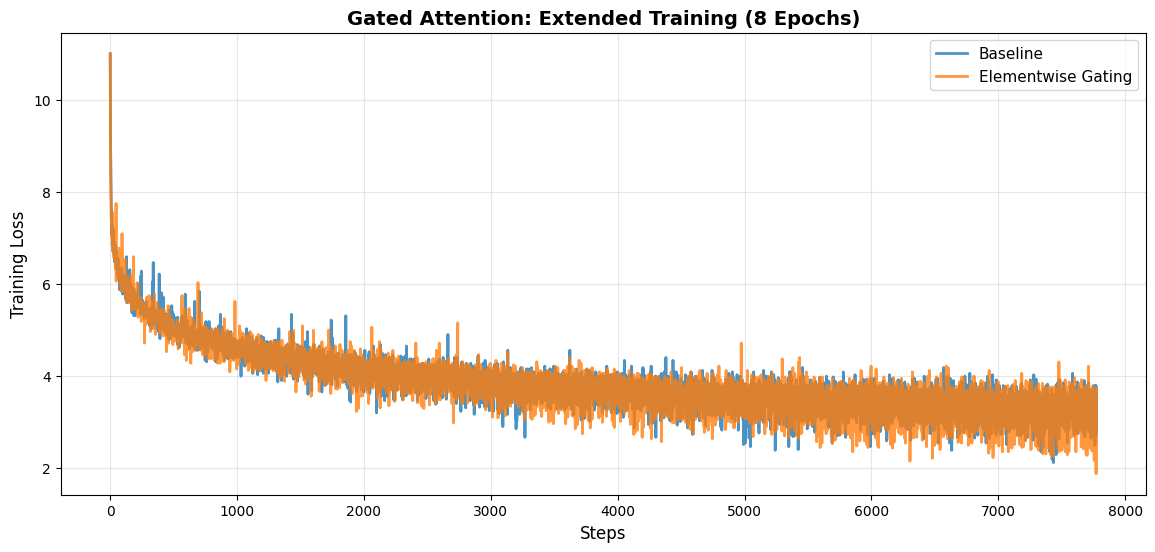

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(baseline_losses_extended, label='Baseline', linewidth=2, alpha=0.8)
plt.plot(elementwise_losses_extended, label='Elementwise Gating', linewidth=2, alpha=0.8)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title(f'Gated Attention: Extended Training ({TOTAL_EPOCHS} Epochs)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

Loading Elementwise Model for Visualization...
,cos size is:torch.Size([1024, 64])
,sin size is:torch.Size([1024, 64])
,cos size is:torch.Size([1024, 64])
,sin size is:torch.Size([1024, 64])
, Loaded weights from gated_attention_checkpoints_v2/Elementwise_Gating_final.pt


/home/mbirada/.conda/envs/h100_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
,  warnings.warn(



,Generating Heatmaps...


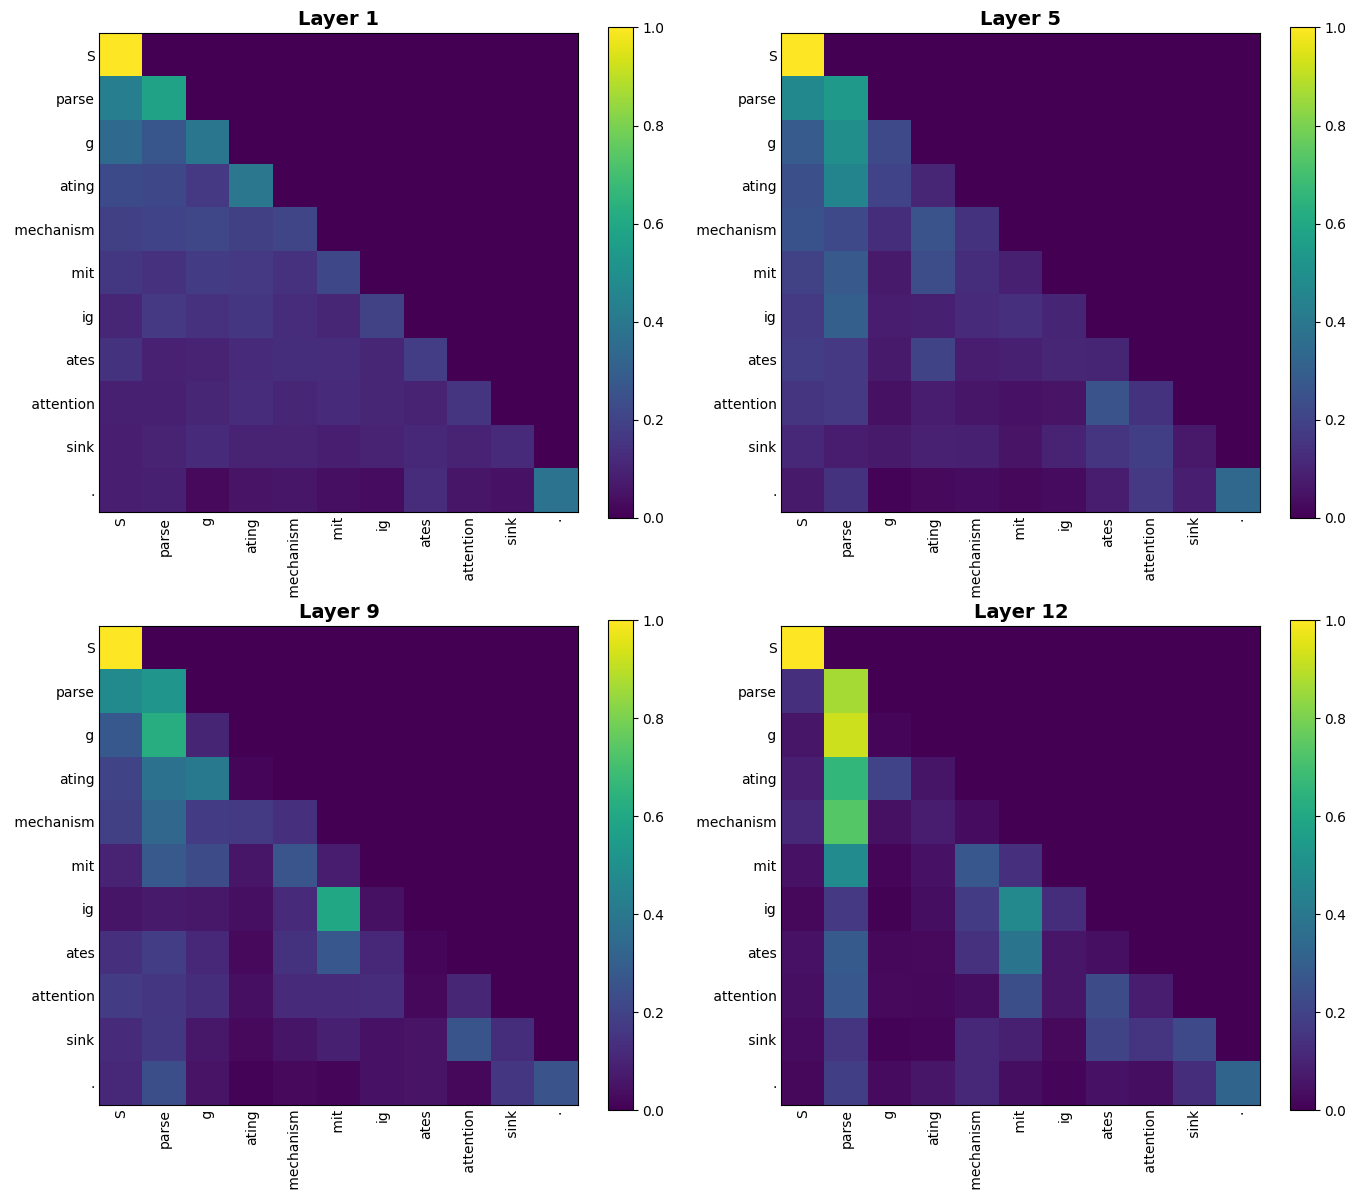

Visualized layers: [1, 5, 9, 12]


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer

class GroupedQueryAttentionViz(GroupedQueryAttention):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_attn_weights = None

    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        if self.gating_type == 'headwise':
            queries = queries.view(b, num_tokens, self.num_kv_groups, -1)
            queries, gate_score = torch.split(queries, [self.head_dim * self.group_size, self.group_size], dim=-1)
            gate_score = gate_score.reshape(b, num_tokens, self.num_heads, 1).transpose(1, 2)
            queries = queries.reshape(b, num_tokens, -1, self.head_dim).transpose(1, 2)
        elif self.gating_type == 'elementwise':
            queries = queries.view(b, num_tokens, self.num_kv_groups, -1)
            queries, gate_score = torch.split(queries, [self.head_dim * self.group_size, self.head_dim * self.group_size], dim=-1)
            gate_score = gate_score.reshape(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
            queries = queries.reshape(b, num_tokens, -1, self.head_dim).transpose(1, 2)
        else:
            queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
            gate_score = None

        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        if self.q_norm: queries = self.q_norm(queries)
        if self.k_norm: keys = self.k_norm(keys)

        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)

        self.last_attn_weights = attn_weights.detach().cpu()

        context = attn_weights @ values
        if gate_score is not None:
            context = context * torch.sigmoid(gate_score)

        context = context.transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

class TransformerBlockViz(TransformerBlock):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.att = GroupedQueryAttentionViz(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            head_dim=cfg["head_dim"],
            num_kv_groups=cfg["n_kv_groups"],
            qk_norm=cfg["qk_norm"],
            gating_type=cfg.get("gating_type", None),
            dtype=cfg["dtype"]
        )
class Qwen3ModelViz(Qwen3Model):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.trf_blocks = nn.ModuleList(
            [TransformerBlockViz(cfg) for _ in range(cfg["n_layers"])]
        )
        if cfg["head_dim"] is None: head_dim = cfg["emb_dim"] // cfg["n_heads"]
        else: head_dim = cfg["head_dim"]
        cos, sin = compute_rope_params(head_dim, cfg["rope_base"], cfg["context_length"])
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)

print("Loading Elementwise Model for Visualization")
viz_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_viz = Qwen3ModelViz(elementwise_config).to(viz_device)

ckpt_path = "gated_attention_checkpoints_v2/Elementwise_Gating_final.pt"
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=viz_device)
    model_viz.load_state_dict(checkpoint['model_state_dict'])
    print(f" Loaded weights from {ckpt_path}")
else:
    print(f" Checkpoint not found at {ckpt_path}. Using random weights (Visualization will be meaningless).")

model_viz.eval()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
text = "Sparse gating mechanism mitigates attention sink."
inputs = tokenizer(text, return_tensors="pt").to(viz_device)
input_ids = inputs["input_ids"]

with torch.no_grad():
    logits = model_viz(input_ids)

print("\nGenerating Heatmaps...")
tokens = [tokenizer.decode([t]) for t in input_ids[0]]

all_attentions = []
for block in model_viz.trf_blocks:
    attn = block.att.last_attn_weights[0]
    avg_attn = attn.mean(dim=0) 
    all_attentions.append(avg_attn.float().numpy())
n_layers = len(all_attentions)
indices = [0, n_layers//3, 2*n_layers//3, n_layers-1]

indices = [i for i in indices if i < n_layers]
indices = sorted(list(set(indices))) 
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, layer_idx in enumerate(indices):
    if i >= 4: break 
    
    ax = axes[i]
    attn_map = all_attentions[layer_idx]
    
    im = ax.imshow(attn_map, cmap="viridis", vmin=0, vmax=1)
    fig.colorbar(im, ax=ax)
    
    ax.set_title(f"Layer {layer_idx + 1}", fontsize=14, fontweight='bold')
    
    # Set ticks
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=10)
    ax.set_yticklabels(tokens, fontsize=10)
    ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()
print(f"Visualized layers: {[i+1 for i in indices]}")